# Exploratory Reddit Data Analysis

Import relevant packages. 
- We are going to need the big three: pandas, numpy, matplotlib. 
- We also will use nltk.corpus to examine stop words.
- From Sklearn, we will pull in
    - train_test_split, cross_val_score
    - Models:
        - LogisticRegression
        - NaiveBayes
        - SVC
        - RandomForestClassifier
        - BaggingClassifier

In [1]:
%%time
import pandas as pd
import numpy as np
import regex as re
import matplotlib.pyplot as plt


from bs4 import BeautifulSoup

from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC

CPU times: user 1.69 s, sys: 613 ms, total: 2.31 s
Wall time: 13.6 s


## Import Data from '_clean.csv_'
Here we are bringing in our cleaned dataset coming from P3-cleaning.pynb

In [2]:
# Bring in the clean data
df = pd.read_csv('../data/clean.csv')

# View a preview
df.head(2)

,title,selftext,clean_title,selftext_urls,title_urls,clean_selftext,created_utc,num_comments,num_crossposts,score,subreddit,Subreddit_name,merged
0,[D] Hinton responds to Schmidhuber,NaN,hinton responds schmidhuber,NaN,NaN,NaN,1587609168,0,0,1,MachineLearning,0,hinton responds schmidhuber
1,Hinton responds to Schmidhuber,NaN,hinton responds schmidhuber,NaN,NaN,NaN,1587609111,1,0,1,MachineLearning,0,hinton responds schmidhuber


### Examine our cleaned data frame

In [3]:
# Check our data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39813 entries, 0 to 39812
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           39813 non-null  object
 1   selftext        23811 non-null  object
 2   clean_title     39783 non-null  object
 3   selftext_urls   8152 non-null   object
 4   title_urls      93 non-null     object
 5   clean_selftext  23806 non-null  object
 6   created_utc     39813 non-null  int64 
 7   num_comments    39813 non-null  int64 
 8   num_crossposts  39813 non-null  int64 
 9   score           39813 non-null  int64 
 10  subreddit       39813 non-null  object
 11  Subreddit_name  39813 non-null  int64 
 12  merged          39793 non-null  object
dtypes: int64(5), object(8)
memory usage: 3.9+ MB


In [4]:
df.isnull().sum()

title                 0
selftext          16002
clean_title          30
selftext_urls     31661
title_urls        39720
clean_selftext    16007
created_utc           0
num_comments          0
num_crossposts        0
score                 0
subreddit             0
Subreddit_name        0
merged               20
dtype: int64

In [5]:
# Drop rows with nan titles
if df.clean_title.isna().sum() > 0:
    df.drop(labels = df[df.clean_title.isna()].index, inplace = True)

# Clean merged column and fillna with empty string
if df.merged.isna().sum() > 0:
    df['merged'].fillna(value="",inplace=True)
    
if df.selftext.isna().sum() > 0:
    df['selftext'].fillna(value="",inplace=True)
    
if df.clean_selftext.isna().sum() > 0:
    df['clean_selftext'].fillna(value="",inplace=True)
    
if df.selftext_urls.isna().sum() > 0:
    df['selftext_urls'].fillna(value="",inplace=True)
    
if df.title_urls.isna().sum() > 0:
    df['title_urls'].fillna(value="",inplace=True)


In [6]:
df.isnull().sum().sum()

0

## Creating custom stop words

Based on examining our data. We see that some words, such as com, www, io, org, edu, https come from being artifacts from extracting URLs. To prevent these from causing interference with our model. We will exclude them as features. 

Also there are a handful of values that occur at high rates distinguishably different from the other subreddit. To extract these, we ran a t-test, and any values that have a low p-value, and specifically those that have extremely high statistic values, were removed to prevent them from over fitting our model.

This practice dramatically improved the variance of our model. Leading to some remarkably consistenet results. 

In [8]:
# sklearn's stopwords, extracted
sklearn_stopwords = list(CountVectorizer(stop_words = 'english').get_stop_words())

#Custom created list
custom_stopwords = ['good','time','python','tool','source','best',
                    'learn','science','machine','deep'
                    'data','learning','science', 'www'] # most common words
url_stopwords = ['com', 'www','io','org','edu', 'https']

# Personalized stopword lists
custom_stopwords.extend(sklearn_stopwords)
custom_stopwords.extend(url_stopwords)
url_stopwords.extend(sklearn_stopwords)

## TRYING SOME EDA

## Frequency of numerical data

In [9]:
df[df.selftext_urls != '']

,title,selftext,clean_title,selftext_urls,title_urls,clean_selftext,created_utc,num_comments,num_crossposts,score,subreddit,Subreddit_name,merged
16,[D] Ethics in AI - Jack Clark from OpenAI talk...,[https://podcasts.apple.com/us/podcast/what-is...,ethics ai jack clark openai talks pandemic gpt,podcasts.apple.com,,https podcasts apple com us podcast probabilit...,1587590317,0,0,1,MachineLearning,0,ethics ai jack clark openai talks pandemic gpt...
18,[R] A snapshot of few-shot classification,Video: [https://video.ias.edu/workshop/2020/04...,r snapshot shot classification,video.ias.edu,,video https video ias edu workshop richardzeme...,1587587959,0,0,1,MachineLearning,0,r snapshot shot classificationvideo https vide...
23,[D] IJCAI — PRICAI 2020 | Papers Announced; Re...,The accepted papers have been announced for IJ...,ijcai pricai papers announced record low accep...,medium.com,,accepted papers announced ijcai pricai total p...,1587575383,1,0,2,MachineLearning,0,ijcai pricai papers announced record low accep...
29,[R] Predictive Early Stopping – Is it possible...,Hey r/MachineLearning! \nTwo years ago we sta...,r predictive early stopping possible predict m...,comet.ml) www.comet.ml,,hey r machinelearning two years ago started wo...,1587566008,8,1,14,MachineLearning,0,r predictive early stopping possible predict m...
31,[R] DPGN: Distribution Propagation Graph Netwo...,Hi fellows! Our team's recent work *DPGN: Dist...,r dpgn distribution propagation graph network ...,arxiv.org github.com,,hi fellows team recent work dpgn distribution ...,1587565653,0,0,1,MachineLearning,0,r dpgn distribution propagation graph network ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39772,Exposing a Word2vec Model with a RESTful API U...,"Hey, all. I was messing around with Jupyter's ...",exposing word vec model restful api using jupy...,tmthyjames.github.io,,hey messing around jupyter kernel gateway last...,1528668821,3,2,13,datascience,1,exposing word vec model restful api using jupy...
39774,In Depth rvest Resources?,I want to get REALLY good at web scraping and ...,depth rvest resources,rpubs.com,,want get really good web scraping using api li...,1528666156,6,0,2,datascience,1,depth rvest resourceswant get really good web ...
39781,What training opportunities would you recommen...,My close friend has an undergrad in Mechanical...,training opportunities would recommend optimal...,csuglobal.edu,,close friend undergrad mechanical engineering ...,1528609105,0,0,0,datascience,1,training opportunities would recommend optimal...
39796,A dataset of basic chemicals and potential all...,A lot of people have food allergy or various k...,dataset basic chemicals potential allergens tr...,world.openfoodfacts.org,,lot people food allergy various kind reactions...,1528545033,6,0,8,datascience,1,dataset basic chemicals potential allergens tr...


In [10]:
df.groupby(by = 'subreddit').mean()

,created_utc,num_comments,num_crossposts,score,Subreddit_name
subreddit,,,,,
MachineLearning,1.566778e+09,5.977060,0.001765,9.233286,0.0
datascience,1.558785e+09,7.715073,0.003609,7.990526,1.0


In [12]:
list_of_words = [len(element) for element in df['title']]

Here we will create a count vectorizer to conduct some EDA

## Count Vectorize our data for _title, selftext, and urls_

In [13]:
#Instantiate Merged Cvec
merged_cvec = CountVectorizer(stop_words = custom_stopwords, min_df=4, max_df = .6)

#Instantiate title Cvec
title_cvec = CountVectorizer(stop_words = custom_stopwords, min_df=4, max_df = .9)

#Instantiate self_text Cvec
selftext_cvec = CountVectorizer(stop_words = custom_stopwords, min_df=4, max_df = .9)

#Instantiate urls Cvec
t_urls_cvec = CountVectorizer(stop_words = url_stopwords, min_df=4)

#Instantiate urls Cvec
st_urls_cvec = CountVectorizer(stop_words = url_stopwords, min_df=4)

# Fit & Transform merged Cvec
merged_term_matrix = merged_cvec.fit_transform(df['merged'])

# Fit & Transform title Cvec
title_term_matrix = title_cvec.fit_transform(df['clean_title'])

# Fit & Transform self_text Cvec
selftext_term_matrix = selftext_cvec.fit_transform(df['clean_selftext'])

# Fit & Transform urls Cvec
title_urls_term_matrix = t_urls_cvec.fit_transform(df['title_urls'])

# Fit & Transform urls Cvec
selftext_urls_term_matrix = st_urls_cvec.fit_transform(df['selftext_urls'])


In [14]:
print(len(merged_cvec.get_feature_names()))
print(len(title_cvec.get_feature_names()))
print(len(selftext_cvec.get_feature_names()))
print(len(t_urls_cvec.get_feature_names()))
print(len(st_urls_cvec.get_feature_names()))

16459
6280
14583
2
414


In [15]:
# Create a dataframe with our term_matrix outputted from Count_vec
merged_term_matrix = merged_cvec.fit_transform(df['merged'])
merged_term_df = pd.DataFrame(merged_term_matrix.toarray(), 
                              columns = merged_cvec.get_feature_names())

title_term_df = pd.DataFrame(title_term_matrix.toarray(), 
                                 columns = title_cvec.get_feature_names())

selftext_term_df = pd.DataFrame(selftext_term_matrix.toarray(), 
                                    columns = selftext_cvec.get_feature_names())

title_urls_term_df = pd.DataFrame(title_urls_term_matrix.toarray(), 
                                    columns = t_urls_cvec.get_feature_names())

selftext_urls_term_df = pd.DataFrame(selftext_urls_term_matrix.toarray(), 
                                    columns = st_urls_cvec.get_feature_names())

# Lets insert our target as "Subreddit"
merged_term_df.insert(0, 'Subreddit_name', df['Subreddit_name'])

# Lets insert our target as "Subreddit"
title_term_df.insert(0, 'Subreddit_name', df['Subreddit_name'])

# Lets insert our target as "Subreddit"
selftext_term_df.insert(0, 'Subreddit_name', df['Subreddit_name'])

# Lets insert our target as "Subreddit"
title_urls_term_df.insert(0, 'Subreddit_name', df['Subreddit_name'])

# Lets insert our target as "Subreddit"
selftext_urls_term_df.insert(0, 'Subreddit_name', df['Subreddit_name'])

## TFIDF Vectorizer

In [16]:
#Instantiate Merged Cvec
merged_tfidf = TfidfVectorizer(stop_words = 'english', min_df=4, max_df = .6)

#Instantiate title Cvec
title_tfidf = TfidfVectorizer(stop_words = 'english', min_df=4, max_df = .9)

#Instantiate self_text Cvec
selftext_tfidf = TfidfVectorizer(stop_words = 'english', min_df=4, max_df = .9)

#Instantiate urls Cvec
t_urls_tfidf = TfidfVectorizer(stop_words = 'english', min_df=4)

#Instantiate urls Cvec
st_urls_tfidf = TfidfVectorizer(stop_words = 'english', min_df=4)

# Fit & Transform merged Cvec
merged_term_tfidf = merged_tfidf.fit_transform(df['merged'])

# Fit & Transform title Cvec
title_term_tfidf = title_tfidf.fit_transform(df['clean_title'])

# Fit & Transform self_text Cvec
selftext_term_tfidf = selftext_tfidf.fit_transform(df['clean_selftext'])

# Fit & Transform urls Cvec
title_urls_term_tfidf = t_urls_tfidf.fit_transform(df['title_urls'])

# Fit & Transform urls Cvec
selftext_urls_term_tfidf = st_urls_tfidf.fit_transform(df['selftext_urls'])


In [17]:
%%time

word_freq_1 = merged_term_df.groupby('Subreddit_name').sum().T.sort_values(by = 1,ascending=False).head(15)
word_freq_0 = merged_term_df.groupby('Subreddit_name').sum().T.sort_values(by = 0,ascending=False).head(15)

CPU times: user 22.3 s, sys: 43.6 s, total: 1min 5s
Wall time: 2min 2s


In [18]:
urls_freq_1 = selftext_urls_term_df.groupby('Subreddit_name').sum().T.sort_values(by=1,ascending=False).head(15)
urls_freq_0 = selftext_urls_term_df.groupby('Subreddit_name').sum().T.sort_values(by=0,ascending=False).head(15)

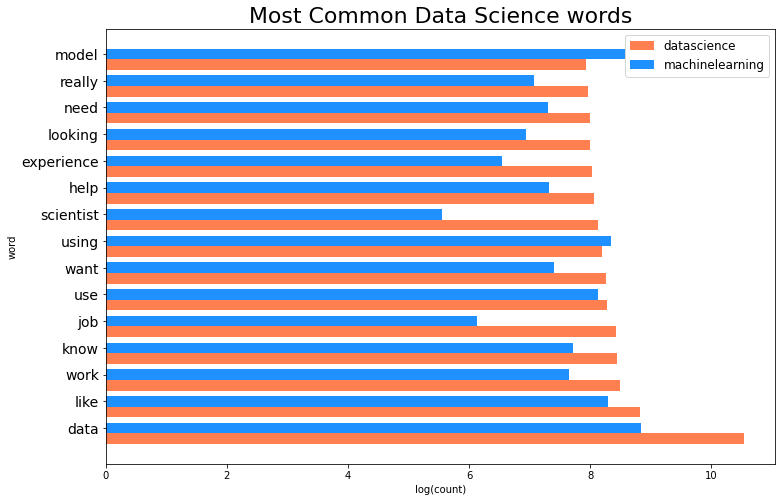

In [20]:
plt.figure(figsize = (12,8))
ind = np.arange(len(word_freq_1))
height = 0.4
plt.barh(width = np.log(word_freq_1[1]), y = ind, height = height, align = 'center', label = 'datascience', color = 'coral')
plt.barh(width = np.log(word_freq_1[0]),y = ind+height, height = height, align = 'center', label = 'machinelearning', color = 'dodgerblue')
plt.yticks(ticks = ind+height, labels = word_freq_1.index, fontsize = 14)
plt.legend(fontsize = 12)
plt.title('Most Common Data Science words', fontsize = 22)
plt.xlabel('log(count)')
plt.ylabel('word')

plt.savefig('../plots/DS_word_logcount.png')

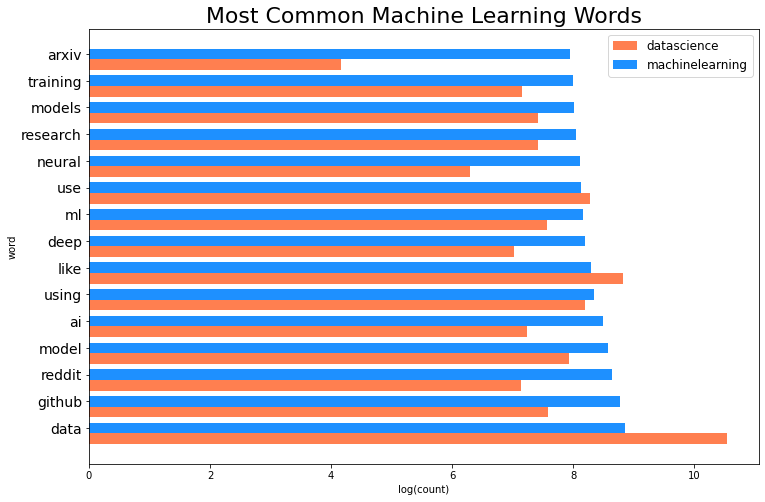

In [21]:
plt.figure(figsize = (12,8))
ind = np.arange(len(word_freq_0))
height = 0.4
plt.barh(width = np.log(word_freq_0[1]), y = ind, height = height, align = 'center', label = 'datascience', color = 'coral')
plt.barh(width = np.log(word_freq_0[0]),y = ind+height, height = height, align = 'center', label = 'machinelearning', color = 'dodgerblue')
plt.yticks(ticks = ind+height, labels = word_freq_0.index, fontsize = 14)
plt.legend(fontsize = 12)
plt.title('Most Common Machine Learning Words', fontsize = 22)
plt.xlabel('log(count)')
plt.ylabel('word')

plt.savefig('../plots/ML_word_logcount.png')

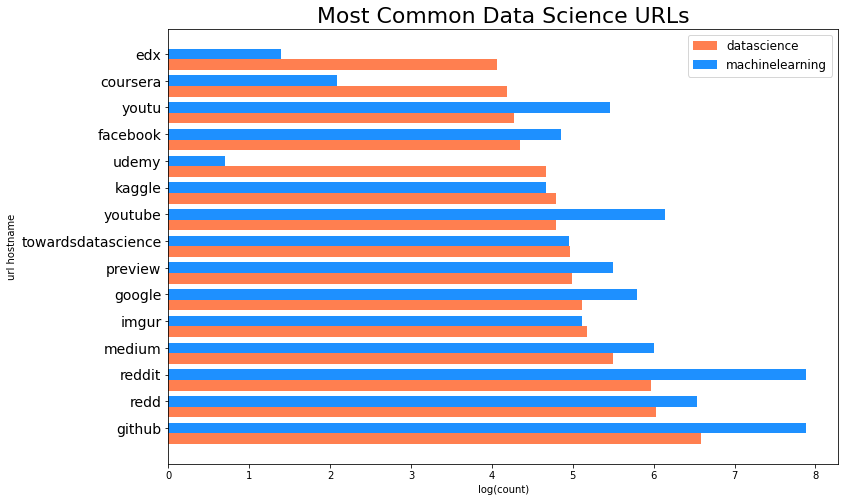

In [22]:
plt.figure(figsize = (12,8))
ind = np.arange(len(urls_freq_1))
height = 0.4
plt.barh(width = np.log(urls_freq_1[1]), y = ind, height = height, align = 'center', label = 'datascience', color = 'coral')
plt.barh(width = np.log(urls_freq_1[0]),y = ind+height, height = height, align = 'center', label = 'machinelearning', color = 'dodgerblue')
plt.yticks(ticks = ind+height, labels = urls_freq_1.index, fontsize = 14)
plt.legend(fontsize = 12)
plt.title('Most Common Data Science URLs', fontsize = 22)
plt.xlabel('log(count)')
plt.ylabel('url hostname')

plt.savefig('../plots/DS_URLS_logcount.png')

**Figure 1:** Here we graphed the common Data Science URL hostnames. In comparison to 

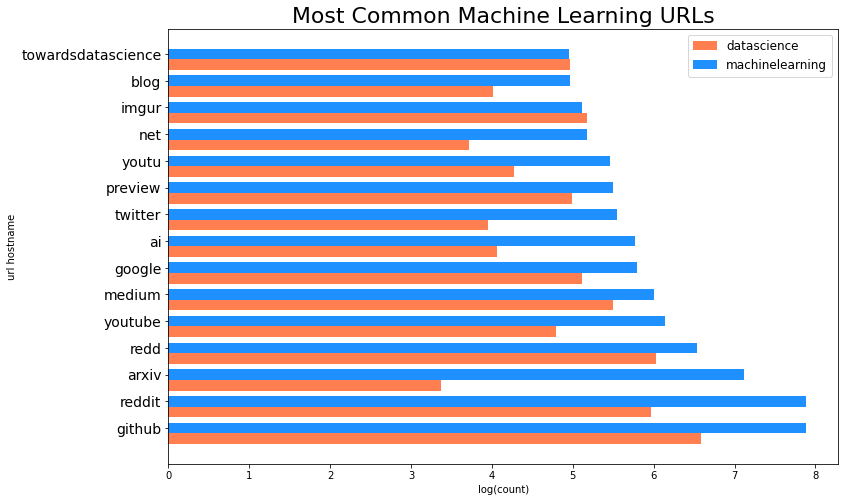

In [23]:
plt.figure(figsize = (12,8))
ind = np.arange(len(urls_freq_0))
height = 0.4
plt.barh(width = np.log(urls_freq_0[1]), y = ind, height = height, align = 'center', label = 'datascience', color = 'coral')
plt.barh(width = np.log(urls_freq_0[0]),y = ind+height, height = height, align = 'center', label = 'machinelearning', color = 'dodgerblue')
plt.yticks(ticks = ind+height, labels = urls_freq_0.index, fontsize = 14)
plt.legend(fontsize = 12)
plt.title('Most Common Machine Learning URLs', fontsize = 22)
plt.xlabel('log(count)')
plt.ylabel('url hostname')

plt.savefig('../plots/ML_URLS_logcount.png')

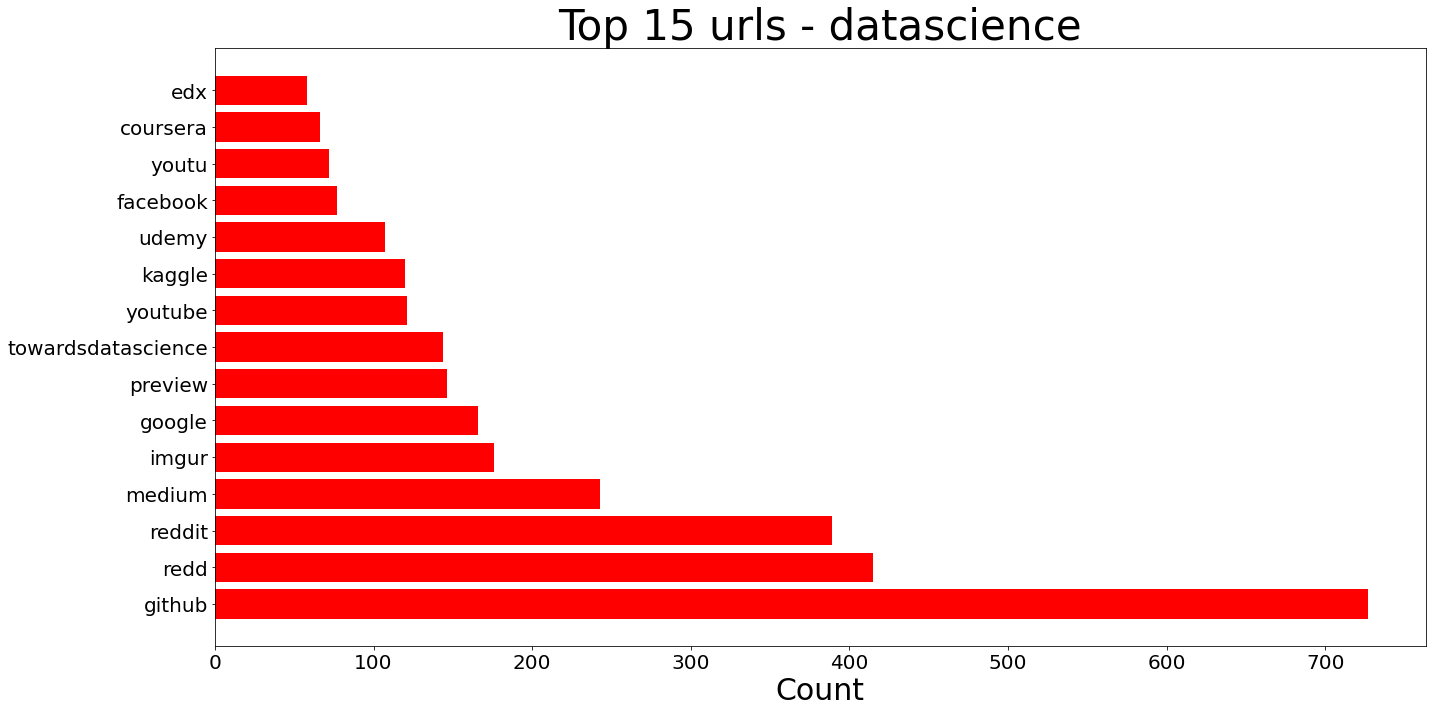

In [24]:
weights = urls_freq_1[1]
labels = urls_freq_1.index
title = 'Top 15 urls - datascience'
def plot_histogram_of_freq(weights, labels, title, color):
    plt.figure(figsize=(20,10))
    plt.barh(labels, weights, color = color)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    plt.xlabel('Count', fontsize=30)
    plt.title(title, fontsize=42)
    plt.tight_layout()

plot_histogram_of_freq(weights, labels, title, 'red')
plt.savefig('../plots/url-ds.png')


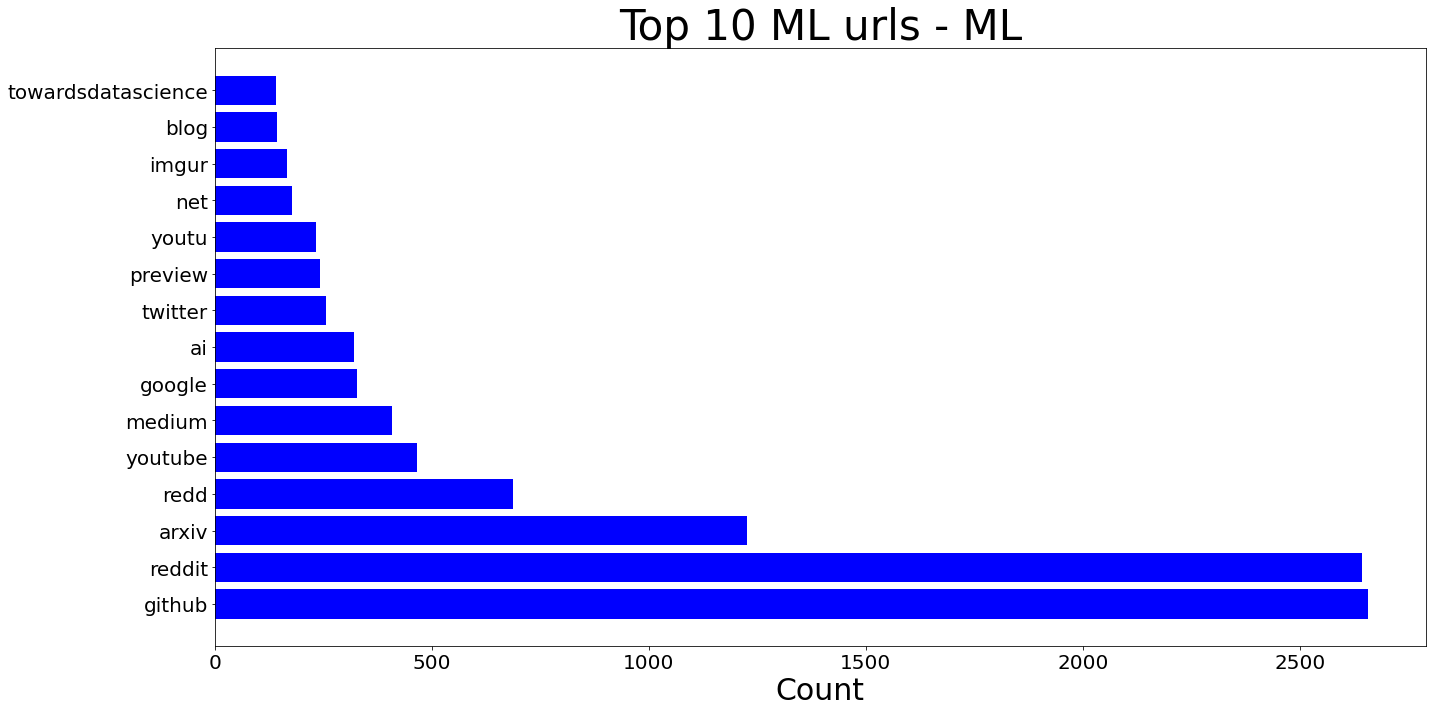

In [25]:
weights = urls_freq_0[0]
labels = urls_freq_0.index
title = 'Top 10 ML urls - ML'
plot_histogram_of_freq(weights, labels, title, 'blue')
plt.savefig('../plots/url-ml.png')


## Get a list of top ML and DS words

Lets create a list of most common ML and DS words, specifically the top 100 words. 

In [32]:
%%time
top_words_ML = list(merged_term_df.groupby('Subreddit_name').
     mean().T.sort_values(0, ascending=False).head(100).index)

top_words_DS = list(merged_term_df.groupby('Subreddit_name').
     mean().T.sort_values(1, ascending=False).head(100).index)

CPU times: user 21.4 s, sys: 42.1 s, total: 1min 3s
Wall time: 1min 36s


### Get a list of overlapping words

In [33]:
# Get list of Overlapping words
top_words_overlap = [element for element in top_words_DS if element in top_words_ML]

Lets check how many of our top 100 words from each subreddit overlap eachother.

In [48]:
len(top_words_overlap)

42

And we could conduct a hypothesis test on this.

$H_0$: The subreddits for DS and ML have the same mean frequency for word $x$.

$H_A$: The subreddits for DS and ML have a different mean frequency for word $x$.

We'll set our alpha at .05

In [35]:
from scipy.stats import ttest_ind

In [36]:
%%time 
ttest_dict = {}

# Cycle through each word in overlap list
for word in top_words_overlap:
    
    # Conduct a t-test, and append the result statistic
    ttest_dict[word] = ttest_ind(merged_term_df[merged_term_df['Subreddit_name']==1][word], # word count in DS
         merged_term_df[merged_term_df['Subreddit_name']==0][word]) # word count dist in ML
    
#ttest_dict

CPU times: user 2min 27s, sys: 4min 47s, total: 7min 14s
Wall time: 12min 51s


In [37]:
# Create a dataframe to examine common top words and their p-values

ttest_df = pd.DataFrame([ttest_dict]).T.sort_values(0)
ttest_df['pvalue'] = [element.pvalue for element in ttest_dict.values()]
ttest_df['statistic'] = [element.statistic for element in ttest_dict.values()]
ttest_df.drop(columns = 0, inplace = True)

In [38]:
# Print out the results of our dataframe
for i in ttest_df.sort_values(by='pvalue').index:
    print(f"{i}: p-value = {ttest_df.sort_values(by='pvalue').loc[i,'pvalue']} \
        t-statistic: {ttest_df.sort_values(by='pvalue').loc[i,'statistic']}")

ai: p-value = 0.0         t-statistic: 65.39314637443277
dataset: p-value = 1.2682174833127348e-143         t-statistic: 25.62227835222862
ml: p-value = 5.504446075358666e-119         t-statistic: 23.270655527302527
model: p-value = 3.448298516619473e-115         t-statistic: 22.887482358810736
really: p-value = 1.210827052154215e-113         t-statistic: -22.729722771735204
research: p-value = 4.546729083412493e-111         t-statistic: 22.464523520948717
different: p-value = 3.3365594084513402e-108         t-statistic: 22.16573013069777
reddit: p-value = 3.424985412705294e-91         t-statistic: 20.3042775675829
based: p-value = 1.874665977108955e-87         t-statistic: 19.872501869964694
github: p-value = 2.377845265922863e-85         t-statistic: 19.62550152408923
code: p-value = 7.1841767123619705e-81         t-statistic: 19.08897274672056
use: p-value = 5.681133750796051e-72         t-statistic: -17.977117509854523
google: p-value = 4.242440795003901e-69         t-statistic: 17

Here we see that most of the words in the machine learning subreddit, are oriented towards 

In [ ]:
weights = coef_df['exp_coef'].head(10).sort_values()
labels = weights.index

plt.figure(figsize=(20,10))
plt.barh(labels, weights, color = 'red')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Exp Coef', fontsize=30)
plt.title(f'Top 10 Features - datascience', fontsize=42)
plt.tight_layout()

In [42]:
ttest_df.sort_values(by=['statistic','pvalue'], ascending = False)[:15]

,pvalue,statistic
ai,0.000000e+00,65.393146
dataset,1.268217e-143,25.622278
ml,5.504446e-119,23.270656
model,3.448299e-115,22.887482
research,4.546729e-111,22.464524
different,3.336559e-108,22.165730
reddit,3.424985e-91,20.304278
based,1.874666e-87,19.872502
github,2.377845e-85,19.625502
code,7.184177e-81,19.088973


In [43]:
ttest_df.sort_values(by=['statistic','pvalue'], ascending = True)[:15]

,pvalue,statistic
really,1.210827e-113,-22.729723
use,5.681134e-72,-17.977118
using,4.739231e-46,-14.264408
think,4.061204e-39,-13.098248
way,5.379948e-34,-12.166627
computer,4.547270e-33,-11.990457
know,6.311123e-24,-10.093454
help,1.270140e-12,-7.099815
thanks,1.160639e-10,-6.446117
want,2.512089e-10,-6.327871


In [ ]:
def plot_cvec_dist(words, dataframe, target = 'Subreddit_name', classes = [0,1]):
    nrows = len(words)//2 if not len(words)%2 else len(words)//2 + 1
    class_0 = dataframe[dataframe[target]==classes[0]]
    class_1 = dataframe[dataframe[target]==classes[1]]
    fig, ax = plt.subplots(ncols=2, nrows=nrows, figsize=(20, 7*nrows))
    ax = ax.ravel()
    
    for i, word in enumerate(words):
        counts_0 = class_0[word].value_counts()[1:].to_dict()
        counts_1 = class_1[word].value_counts()[1:].to_dict()
        mean_0 = class_0[word].mean()
        mean_1 = class_1[word].mean()
        ax[i].bar(counts_0.keys(), counts_0.values(), color='goldenrod', alpha=.3)
        for keys, values in counts_0.items():
            ax[i].text(keys-.1, values, s=values, fontsize=14, color='goldenrod')
        for keys, values in counts_1.items():
            ax[i].text(keys+.1, values, s=values, fontsize=14, color='grey')
        ax[i].bar(counts_1.keys(), counts_1.values(), color='grey', alpha=.3)
        ymin, ymax = ax[i].get_ylim()
        ax[i].plot([mean_0]*2, [ymin, ymax], ':', color='goldenrod')
        ax[i].plot([mean_1]*2, [ymin, ymax], ':', color='grey')
        ax[i].set_title(f'{word} frequency counts\nmeans: {mean_0:0.02f} vs {mean_1:0.02f}')
        ax[i].legend(classes)

In [ ]:
plot_cvec_dist(top_words_overlap, term_df)